# Model Inference
Infer from a cosmological model via MCMC samplers. 

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.66' # NOTE: jax preallocates GPU (default 75%)
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, config as jconfig, jit, vmap, grad, debug, tree
jconfig.update("jax_enable_x64", True)

from functools import partial
from getdist import plots
from numpyro import infer

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload
from montecosmo.mcbench import sample_and_save
from montecosmo.script import from_id, get_mcmc, get_init_mcmc, get_sqrt_diag_cov_from_numpyro

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("infer")
# !jupyter nbconvert --to script ./src/montecosmo/tests/infer_model.ipynb/

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname

feynmangpu04.cluster.local


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Config and fiduc

In [2]:
################## TO SET #######################
# task_id = int(os.environ['SLURM_ARRAY_TASK_ID'])
# m, ev, lo, rsdb, pc, samp, mm
task_id = 2112231
print("SLURM_ARRAY_TASK_ID:", task_id)
model, mcmc_config, save_dir, save_path = from_id(task_id)
os.makedirs(save_dir, exist_ok=True)
print("save path:", save_path)

# import sys
# tempstdout, tempstderr = sys.stdout, sys.stderr
# sys.stdout = sys.stderr = open(save_path+'.out', 'a')
# job_id = int(os.environ['SLURM_ARRAY_JOB_ID'])
# print("SLURM_ARRAY_JOB_ID:", job_id)
# print("SLURM_ARRAY_TASK_ID:", task_id)
# print("jax_enable_x64:", jconfig.read("jax_enable_x64"))

SLURM_ARRAY_TASK_ID: 2112231
save path: /feynman/home/dphp/hs276503/scratch/pickles/m32_b160.0_ao0.5_evlpt_lo1_pckaiser_obfield/sMCLMC_nc4_ns64


# CONFIG
{'a_obs': 0.5,
 'box_shape': array([160., 160., 160.]),
 'evolution': 'lpt',
 'gxy_density': 0.001,
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'loc_fid': 0.3111,
                         'low': 0.05,
                         'scale': 0.5,
                         'scale_fid': 0.06},
             'b1': {'group': 'bias',
                    'label': '{b}_1',
                    'loc': 1.0,
                    'loc_fid': 1.0,
                    'scale': 0.5,
                    'scale_fid': 0.5},
             'b2': {'group': 'bias',
                    'label': '{b}_2',
                    'loc': 0.0,
                    'loc_fid': 0.0,
                    'scale': 2.0,
                    'scale_fid': 2.0},
             'bn2': {'group': 'bias',
                     'label': '{b}_{\\nabla^2}',
                     'loc': 0.0,
   

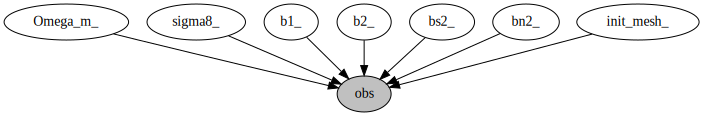

In [3]:
print(model)
print(mcmc_config)
# model.render()

if not os.path.exists(save_dir+"truth.p"):
    # Predict and save fiducial
    truth = {'Omega_m': 0.31, 
            'sigma8': 0.81, 
            'b1': 1.,
            'b2':0., 
            'bs2':0., 
            'bn2': 0.}
    
    if model.loc_fid['b1'] == 0:
        truth['b1'] = 0.

    model.reset()
    truth = model.predict(samples=truth, hide_base=False, hide_samp=False, frombase=True)
    
    print(f"Saving model and truth at {save_dir}")
    model.save(save_dir+"model.p")    
    pdump(truth, save_dir+"truth.p")
else:
    print(f"Loading truth from {save_dir}")
    truth = pload(save_dir+"truth.p")

model.reset()
if model.loc_fid['b1'] == 0:
    print('no bias')
    model.condition({'obs': truth['obs'], 'b1': truth['b1'], 'b2': truth['b2'], 'bs2': truth['bs2'], 'bn2': truth['bn2']}, frombase=True)
    # model.condition({'obs': truth['obs'], 'bn2': truth['bn2']}, frombase=True)
else:
    model.condition({'obs': truth['obs']})
model.block()
model.render()

## Run

### NUTS, HMC

In [ ]:
continue_run = False
if continue_run:
    pass
else:
    model.reset()
    model.condition({'obs': truth['obs']} | model.loc_fid, frombase=True)
    model.block()

    mcmc = get_init_mcmc(model.model, mcmc_config['n_chains'])    
    init_params_ = jit(vmap(partial(model.init_model, delta_obs=truth['obs']-1)))(jr.split(jr.key(45), mcmc.num_chains))
    # init_params_ = model.predict(45, samples=mcmc.num_chains, hide_samp=False)
    
    if not os.path.exists(save_path + "_init_last_state.p"):
        print("# Warmupping...")
        init_mesh_ = {k: init_params_[k] for k in ['init_mesh_']} # NOTE: !!!!!!!
        mcmc = sample_and_save(mcmc, save_path+'_init', 0, 0, extra_fields=['num_steps'], init_params=init_mesh_)
        ils = mcmc.last_state.z
    else:
        print("# Loading init_last_state")
        ils = pload(save_path + "_init_last_state.p").z
    
    # ils = {k: jnp.broadcast_to(v, (mcmc_config['n_chains'], *jnp.shape(v))) for k, v in truth.items()}
    # ils = {k+'_': ils[k+'_'] for k in ['Omega_m','sigma8','b1','b2','bs2','bn2','init_mesh']}

    ################
    from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh
    mesh0 = jnp.fft.irfftn(truth['init_mesh'])
    kptcs__ = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init_params_)
    kptcs_ = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init_params_ | ils)
    kpk0 = model.spectrum(mesh0)
    kptc_obs = model.powtranscoh(mesh0, truth['obs'] - 1)
    kpkobs = model.spectrum(truth['obs']-1)
    
    print(ils.keys(), init_params_.keys())

    mse__ = jnp.mean((vmap(lambda x: model.reparam(x, fourier=False))(init_params_)['init_mesh']  - mesh0)**2, axis=(1,2,3))
    mse_ = jnp.mean((vmap(lambda x: model.reparam(x, fourier=False))(init_params_ | ils)['init_mesh']  - mesh0)**2, axis=(1,2,3))
    print("MSEs:", mse_, mse_)

    prob = 0.95
    plt.figure(figsize=(12, 4))
    plot_powtranscoh(*jnp.median(jnp.stack(kptcs__), 1), label='init')
    plot_powtranscoh(*kptcs__, fill=prob)
    plot_powtranscoh(*jnp.median(jnp.stack(kptcs_), 1), label='warm')
    plot_powtranscoh(*kptcs_, fill=prob)
    plt.subplot(131)
    plot_pow(*kpk0, 'k', label='true')
    plot_pow(*kpkobs, ':', c='grey', label='obs')
    plt.legend()
    plt.subplot(133)
    plot_coh(kptc_obs[0], kptc_obs[-1], ':', c='grey', label='obs')
    plt.tight_layout()
    plt.savefig(save_dir+f'init_glin_{task_id}.png')
    # plt.savefig(f'init_glin_{task_id}.png')
    ################    
    
    if model.loc_fid['b1'] == 0:
        print('no bias')
        init_params_ = {k:v for k,v in init_params_.items() if k in ['Omega_m_', 'sigma8_']} | ils
        # init_params_ = {k:v for k,v in init_params_.items() if k in ['Omega_m_', 'sigma8_','b1_','b2_','bs2_']} | ils
    else:
        init_params_ |= ils
        # init_params_ |= mcmc.last_state.z
    print(init_params_.keys())

    sqrt_diag_cov = vmap(partial(get_sqrt_diag_cov_from_numpyro, all=False))(pload(save_path + "_init_last_state.p"), init_params_)
    print(sqrt_diag_cov)

model.reset()
if model.loc_fid['b1'] == 0:
    print('no bias')
    model.condition({'obs': truth['obs'], 'b1': truth['b1'], 'b2': truth['b2'], 'bs2': truth['bs2'], 'bn2': truth['bn2']}, frombase=True)
    # model.condition({'obs': truth['obs'], 'bn2': truth['bn2']}, frombase=True)
else:
    model.condition({'obs': truth['obs']})
model.block()

2025-02-13 18:12:24.513178: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [ ]:
from tqdm import tqdm
if mcmc_config['sampler'] in ['NUTS', 'HMC']:
    mcmc = get_mcmc(model.model, mcmc_config)
    if continue_run:
        print(f"{jnp.result_type(True)=}") # HACK: why is it working?!!
        mcmc.num_warmup = 0
        mcmc.post_warmup_state = pload(save_path + "_last_state.p")
        start = 3 ###############
        end = start + mcmc_config['n_runs'] - 1
        mcmc_runned = sample_and_save(mcmc, save_path, start, end, rng=44, extra_fields=['num_steps'])

    else:
        # mcmc_runned = sample_and_save(mcmc, save_path, 0, mcmc_config['n_runs'], extra_fields=['num_steps'], init_params=init_params_)
        mcmc_runned = sample_and_save(mcmc, save_path, 0, 0, extra_fields=['num_steps'], init_params=init_params_)
       

elif mcmc_config['sampler'] == 'NUTSWG':
    from montecosmo.samplers import nutswg_init, get_nutswg_warm, get_nutswg_run
    n_samples, n_runs, n_chains = mcmc_config['n_samples'], mcmc_config['n_runs'], mcmc_config['n_chains']

    step_fn, init_fn, conf, init_state_fn = nutswg_init(model.logpdf)

    # warmup_fn = jit(vmap(get_nutswg_warm(model.logpdf, conf, mcmc_config['n_samples'], progress_bar=False)))
    # state = jit(vmap(init_state_fn))(init_params_)

    # samples, infos, state, conf = warmup_fn(jr.split(jr.key(43), n_chains), state)
    # print("conf:", conf,
    #         "\n\ninfos:", infos, '\n#################\n')
    # jnp.savez(save_path+f"_{0}.npz", **samples | {k:infos[k] for k in ['n_evals']})
    # pdump(state, save_path+f"_last_state.p")
    # pdump(conf, save_path+'_conf.p'), pdump(tree.map(jnp.mean, infos), save_path+'_infos.p')

    conf = pload(save_path+'_conf.p')
    state = pload(save_path+'_last_state.p')
    
    run_fn = jit(vmap(get_nutswg_run(model.logpdf, step_fn, init_fn, n_samples, progress_bar=False)))
    start = 1 ######
    end = start + n_runs - 1
    key = jr.key(42)
    for i_run in tqdm(range(start, end+1)):
        print(f"run {i_run}/{end}")
        key, run_key = jr.split(key, 2)
        samples, infos, state = run_fn(jr.split(run_key, n_chains), state, conf)
        print("infos:", tree.map(lambda x: jnp.mean(x, 1), infos))
        jnp.savez(save_path+f"_{i_run}.npz", **samples | {k:infos[k] for k in ['n_evals']})
        pdump(state, save_path+f"_last_state.p")

elif mcmc_config['sampler'] == 'MCLMC':
    from montecosmo.samplers import get_mclmc_warmup, get_mclmc_run
    from jax.flatten_util import ravel_pytree

    if mcmc_config['mm']:
        sdc = ravel_pytree(tree.map(lambda x:x.mean(0), sqrt_diag_cov))[0]
    else:
        sdc = 1.
        
    config = None
    # config = {'L':193, 'step_size': 45,} # 64^3
    # config = {'L':500, 'step_size': 10,} # 64^3 norsdb
    # config = {'L':350, 'step_size': 3,} # 64^3 a=.5
    # config = {'L':700, 'step_size':45, 'inverse_mass_matrix':sdc**2} # 64, 128^3 a=.5

    warmup_fn = jit(vmap(get_mclmc_warmup(model.logpdf, n_samples=2**13, config=config, 
                                          desired_energy_var=5e-5, diagonal_preconditioning=mcmc_config['mm'])))
    state, config = warmup_fn(jr.split(jr.key(43), mcmc_config['n_chains']), init_params_)
    pdump(state, save_path+f"_last_state.p")
    pdump(config, save_path+f"_conf.p")

    # state = pload(save_path+f"_last_state.p")
    # config = pload(save_path+f"_conf.p")
    print(config)
    n_samples, n_runs, n_chains = mcmc_config['n_samples'], mcmc_config['n_runs'], mcmc_config['n_chains']

    thinning = 32
    run_fn = jit(vmap(get_mclmc_run(model.logpdf, n_samples, thinning=thinning, progress_bar=False)))

    start = 1 ######
    end = start + n_runs - 1
    key = jr.key(42)
    for i_run in tqdm(range(start, n_runs + start)):
        print(f"run {i_run}/{n_runs}")
        key, run_key = jr.split(key, 2)
        state, samples = run_fn(jr.split(run_key, n_chains), state, config)
        
        print("\nmean square energy fluctation per dim:", jnp.mean(samples['mse_per_dim'], 1), '\n')
        jnp.savez(save_path+f"_{i_run}.npz", **samples)
        pdump(state, save_path+f"_last_state.p")

Adaptation start: finding L, ss, mm
fractune3=0


KeyboardInterrupt: 